# BENCHMARK: 

- Train RMSE: 3_448
- Validation RMSE: 3_049

# Imports:

In [615]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from functools import partial
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline

from numba import njit
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from window_ops.rolling import rolling_mean
from xgboost import XGBRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

# MLForecast_Evaluator class definition for models evaluation and prediction:

In [616]:
class MLForecast_Evaluator:
    def __init__(self, fcst, valid, future_df, h=1):
        self.fcst = fcst
        self.valid = valid
        self.future_df = future_df
        self.h = h
        self.mean_rmse_valid = None # To use for filename (mean rmse of all models)
        
        # Generate predictions
        self.predictions = fcst.predict(h=self.h, X_df=future_df)
        
        # Merge predictions with valid set
        self.results = valid.merge(self.predictions, on=['unique_id', 'ds'])
        
        # Get fitted values (train predictions)
        self.train_preds = fcst.forecast_fitted_values()
        
        # Identify model columns
        self.model_columns = list(fcst.models.keys())
        
    def plot_time_series(self, n_samples: int = 4, figsize: tuple = None, random_state: Optional[int] = None):
        """
        Plots the time series for a random sample of unique_ids.
        
        Parameters
        ----------
        """
        
        # Sample random unique_ids
        unique_ids = self.train_preds['unique_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=min(n_samples, len(unique_ids)), replace=False)
        
        # Calculate grid dimensions
        n_cols = math.ceil(math.sqrt(n_samples))
        n_rows = math.ceil(n_samples / n_cols)
        
        # Calculate adaptive figsize if not provided
        if figsize is None:
            figsize = (7 * n_cols, 4 * n_rows)
        
        # Create subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle('Time Series Visualization', fontsize=16)

        axs = axs.flatten() if n_samples > 1 else [axs]

        # List to store handles and labels for the legend
        handles, labels = [], []

        for i, unique_id in enumerate(sampled_ids):
            train_data = self.train_preds[self.train_preds['unique_id'] == unique_id]
            valid_data = self.results[self.results['unique_id'] == unique_id]

            # Plot train data
            h_train, = axs[i].plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='black')
            if 'Actual (Train)' not in labels:
                handles.append(h_train)
                labels.append('Actual (Train)')

            for model in self.model_columns:
                h_model_train, = axs[i].plot(train_data['ds'], train_data[model], label=f'{model} (Train)')
                if f'{model} (Train)' not in labels:
                    handles.append(h_model_train)
                    labels.append(f'{model} (Train)')
            
            # Plot valid data
            h_valid, = axs[i].plot(valid_data['ds'], valid_data['y'], label='Actual (Valid)', color='red', linestyle='--')
            if 'Actual (Valid)' not in labels:
                handles.append(h_valid)
                labels.append('Actual (Valid)')

            for model in self.model_columns:
                h_model_valid = axs[i].scatter(valid_data['ds'], valid_data[model], label=f'{model} (Valid)')
                if f'{model} (Valid)' not in labels:
                    handles.append(h_model_valid)
                    labels.append(f'{model} (Valid)')

            axs[i].set_title(f'Time Series - ID: {unique_id}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('Value')
        
        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        
        # Add a single legend for all subplots
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=len(self.model_columns) + 2, fontsize='small')
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
        plt.show()

    def calculate_metrics(self) -> pd.DataFrame:
        metrics = {}

        for model in self.model_columns:
            model_metrics = {}
            for result_df, name in zip([self.train_preds, self.results], ['train', 'valid']):
                y_true = result_df['y']
                y_pred = result_df[model]

                model_metrics[f'RMSE_{name}'] = np.sqrt(mean_squared_error(y_true, y_pred))
                model_metrics[f'R2_{name}'] = r2_score(y_true, y_pred)

            metrics[model] = model_metrics

        metrics_df = pd.DataFrame(metrics).T

        # Find the model with the lowest validation RMSE
        lowest_rmse_model = metrics_df['RMSE_valid'].idxmin()
        lowest_rmse_value = metrics_df.loc[lowest_rmse_model, 'RMSE_valid']
        
        self.mean_rmse_valid = metrics_df['RMSE_valid'].mean()  # Calculate and store mean RMSE for submission

        print(f"MEAN RMSE_VALID = {self.mean_rmse_valid}\n")
        print(f"Model with lowest RMSE validation is {lowest_rmse_model} with RMSE = {lowest_rmse_value}\n")
        print(metrics_df.sort_values(by='RMSE_valid'))

        return metrics_df.sort_values(by='RMSE_valid')
    
    def plot_feature_importances(self):
        # Initialize an empty DataFrame to store the feature importances
        df = pd.DataFrame()

        # Loop through each model to get its feature importances
        for model in self.model_columns:
            feature_importances = self.fcst.models_[model].feature_importances_
            feature_names = self.fcst.ts.features_order_

            # Create a temporary DataFrame for the current model
            temp_df = pd.DataFrame(feature_importances, columns=[model], index=feature_names)

            # Merge the temporary DataFrame with the main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')

        # Fill NaNs with 0 (if any feature is missing in some models)
        df = df.fillna(0)
        # Scale the feature importances between 0 and 1 for each model
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

        # Sort features by their average importance
        average_importance = df_scaled.mean(axis=1)
        sorted_features = average_importance.sort_values(ascending=True).index[-50:]

        # Reorder DataFrame according to the sorted feature list
        df_scaled = df_scaled.loc[sorted_features]

        # Plotting the horizontal multi-bar plot
        fig, ax = plt.subplots(figsize=(10, 15))

        # Define the height of the bars and the positions for each group
        bar_height = 0.15
        index = np.arange(len(sorted_features))

        # Loop through each model and plot its feature importances
        for i, model in enumerate(self.model_columns):
            ax.barh(index + i * bar_height, df_scaled[model], bar_height, label=model)

        # Add labels, title, and legend
        ax.set_ylabel('Feature')
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Scaled Feature Importances by Model')
        ax.set_yticks(index + bar_height * (len(self.model_columns) - 1) / 2)
        ax.set_yticklabels(sorted_features)
        ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_metrics(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1: Scatter plot of predicted vs actual values
        for model in self.model_columns:
            # Scatter plot
            sns.scatterplot(x=self.results[model], y=self.results['y'], label=model, ax=ax1, alpha=0.7)
            
            # Fit line
            X = self.results[model].values.reshape(-1, 1)
            y = self.results['y'].values
            reg = LinearRegression().fit(X, y)
            ax1.plot(X, reg.predict(X))

        # Plot the perfect prediction line
        min_val = min(self.results['y'].min(), self.results[self.model_columns].min().min())
        max_val = max(self.results['y'].max(), self.results[self.model_columns].max().max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')
        ax1.set_title('Validation Set: Predicted vs Actual')
        ax1.legend(title='Model')

        # Plot 2: Distribution of Residuals
        scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
        palette = sns.color_palette(n_colors=len(self.model_columns))
        
        for i, model in enumerate(self.model_columns):
            # Calculate residuals
            residuals = self.results['y'] - self.results[model]
            
            # Remove infinite values and extreme outliers
            mask = np.isfinite(residuals) & (np.abs(residuals) < np.percentile(np.abs(residuals), 99))
            clean_residuals = residuals[mask]
            
            if len(clean_residuals) > 0:
                # Scale the residuals
                residuals_scaled = scaler.fit_transform(clean_residuals.values.reshape(-1, 1)).flatten()
                
                # Plot KDE with increased bandwidth
                #sns.kdeplot(residuals_scaled, label=model, ax=ax2, bw_adjust=1.5, color=palette[i])
                sns.histplot(residuals_scaled, bins=30, label=model, kde=False, color=palette[i], alpha=0.5, ax=ax2)
                
                # Add rug plot
                #sns.rugplot(residuals_scaled, ax=ax2, color=palette[i], alpha=0.7)
            else:
                print(f"Warning: No valid residuals for model {model}")

        ax2.set_title('Distribution of Scaled Residuals')
        ax2.set_xlabel('Scaled Residual')
        ax2.set_ylabel('Density')
        ax2.legend(title='Model', fontsize=16) #change legend size
        
        # Set x-axis limits for better visibility
        ax2.set_xlim(-5, 5)

        plt.tight_layout()
        plt.show()


    def predict_save_submission(self, model_name, test_index):
        
        if model_name not in self.model_columns:
            raise ValueError(f"Model '{model_name}' not found. Available models are: {', '.join(self.model_columns)}")

        test_preds = self.predictions[self.predictions['ds'].isin(test_index)] #Test index was defined in split
        test_preds = test_preds[['unique_id', model_name]]
        
        # Rename the model column to 'monthly_sales'
        test_preds.rename(columns={model_name: 'monthly_sales'}, inplace=True)

        # Get today's date for the filename
        today = date.today()

        if self.mean_rmse_valid is None:
            print("Warning: mean_rmse_valid has not been calculated yet. Using 'unknown' in filename.")
            mean_rmse_str = "unknown"
        else:
            mean_rmse_str = f"{self.mean_rmse_valid:.4f}"  # Format to 4 decimal places

        output_filename = f"submissions\submission_{model_name}_mean_valid_RMSE_{mean_rmse_str}_{today}.csv"
        test_preds.to_csv(output_filename, index=False)

        print(f"Submission file '{output_filename}' has been created successfully.")

        return test_preds

# Data Load:

In [617]:
path = r'.\data\ts_kaggle_train.csv'
data = pd.read_csv(path, index_col=0, parse_dates=['date'])

### Transform to MLforecast nomenclature and save columns in useful lists:

In [618]:
# target = y
data.rename(columns={'date': 'ds', 'monthly_sales': 'y'}, inplace=True)

In [619]:
core_features = ['ds','unique_id']
static_features = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# NaN imputation:

- First test:
    - Imput target with 0 (NaN means no sales)
    - Imput monthly_average_price with fill with previous value (bfill) and next value (ffill)

- Second test: KNNimputer

### Second test: KNNimputer

In [620]:
data.isnull().sum()

ds                          0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
y                         728
dtype: int64

In [621]:
# Create a copy of the original data to avoid modifications
data_temp = data.copy()

# Extract time-based features from the 'ds' column because KNN needs numeric features
data_temp['month'] = data_temp['ds'].dt.month
data_temp['year'] = data_temp['ds'].dt.year
data_temp['quarter'] = data_temp['ds'].dt.quarter
#data_temp['around_Xmas'] = data_temp['ds'].dt.month.isin([1,12])
#data_temp['before_Xmas'] = data_temp['ds'].dt.month == 12

# Columns to impute using KNN
cols_with_missing = ['monthly_average_price', 'y']

# Drop unnecessary columns and create a copy for imputation
data_impute = data_temp.drop(columns=['ds', 'unique_id']).copy()

# Fit and transform the KNN imputer
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(data_impute)

# Create a DataFrame with the imputed values
imputed_df = pd.DataFrame(imputed_values, columns=data_impute.columns, index=data_impute.index)

# Merge the imputed columns with the original data, excluding the imputed ones
data_final = imputed_df[cols_with_missing].merge(
    data_temp.drop(columns=cols_with_missing), how='right', left_index=True, right_index=True
)

data = data_final.copy()

In [622]:
test_index = [sorted(list(data["ds"].unique()))[-1]]
data['y'] = np.where(data['ds'].isin(test_index), 0, data['y'])

# Feature creation

### Drop quarter after "feature importance" check

In [623]:
#data.drop(columns=['quarter'], inplace=True)

### Revenue

In [624]:
data["revenue"] = (data["y"] * data["monthly_average_price"])

### By groups

In [625]:
def build_ts_features(df, cols_to_group, target_column, lags, aggfunc, include_diff=False):

    # Error control for lags
    if not isinstance(lags, list):
        raise ValueError("Lags should be a list of integers.")
    
    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group)
    
    # Set the index and perform grouping, resampling, and aggregation in one step
    grouped_df = (
        df.set_index("ds")
        .groupby(cols_to_group + [pd.Grouper(freq="M")])
        [target_column]
        .agg(aggfunc)
        .reset_index()
    )
    
    # Generate lag and diff features for specified lags
    for n in lags:
        lag_col_name = f"{new_name}_{target_column}_{aggfunc.__name__}_lag_{n}"
        grouped_df[lag_col_name] = grouped_df.groupby(cols_to_group)[target_column].shift(n)

        if include_diff:
            diff_col_name = f"{new_name}_{target_column}_{aggfunc.__name__}_diff_{n}"
            grouped_df[diff_col_name] = grouped_df.groupby(cols_to_group)[target_column].diff(n)
    
    # Merge the generated features back into the original DataFrame
    merge_cols = ['ds', target_column] + cols_to_group
    df = pd.merge(df, grouped_df, on=merge_cols, how='left')
  
    return df

#### By item_id

In [626]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['y', 'revenue']
groups = [
    ['item_id'] 
]
agg_functions = [np.sum]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = build_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                    lags=[1,2]
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 12)
Final DataFrame shape: (14484, 16)


In [627]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   monthly_average_price      14484 non-null  float64       
 1   y                          14484 non-null  float64       
 2   ds                         14484 non-null  datetime64[ns]
 3   unique_id                  14484 non-null  object        
 4   city_id                    14484 non-null  int64         
 5   shop_id                    14484 non-null  int64         
 6   item_category_id           14484 non-null  int64         
 7   item_id                    14484 non-null  int64         
 8   month                      14484 non-null  int32         
 9   year                       14484 non-null  int32         
 10  quarter                    14484 non-null  int32         
 11  revenue                    14484 non-null  float64       
 12  item

In [628]:
data.drop('revenue', axis=1, inplace=True)

# Train, Validation, Test Split & Future dataset creation:

Future_df incorporates all exogenous dynamic features and is passed before prediction.

In [629]:
train_index = sorted(list(data["ds"].unique()))[:-2]
valid_index = [sorted(list(data["ds"].unique()))[-2]]
test_index = [sorted(list(data["ds"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valid_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



**Drop Revenue cause of leakage**

In [630]:
#data.drop('revenue', axis=1, inplace=True)

In [631]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
test = data.loc[data['ds'].isin(test_index)]

In [632]:
all_features = list(train.columns)
dynamic_features = list(set(all_features) - set(static_features) - set('y'))

In [633]:
future_df = data[dynamic_features]

# MLforecast model creation:

## Models:

In [634]:
xgb_simple = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,   # A common default value
    random_state=42
)

xgb_complex = XGBRegressor(
    n_estimators=200,
    max_depth=3,           # Limit tree depth to prevent overfitting
    learning_rate=0.05,    # Reduce learning rate for more gradual learning
    subsample=0.8,         # Use 80% of data to grow trees to control overfitting
    colsample_bytree=0.8,  # Use 80% of features to grow trees to control overfitting
    random_state=42
)

models = [xgb_simple, xgb_complex]

## Target lags and transformations:

In [635]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq='M',
    target_transforms=[GlobalSklearnTransformer(sk_log1p)]
)

### Save transformed data:

In [636]:
transform_data = fcst.preprocess(data, dropna=False)
#transform_data

## Train and fit all models

In [637]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=static_features)

MLForecast(models=[XGBRegressor, XGBRegressor2], freq=M, lag_features=[], date_features=[], num_threads=1)

# Evaluate on validation set (h=1)

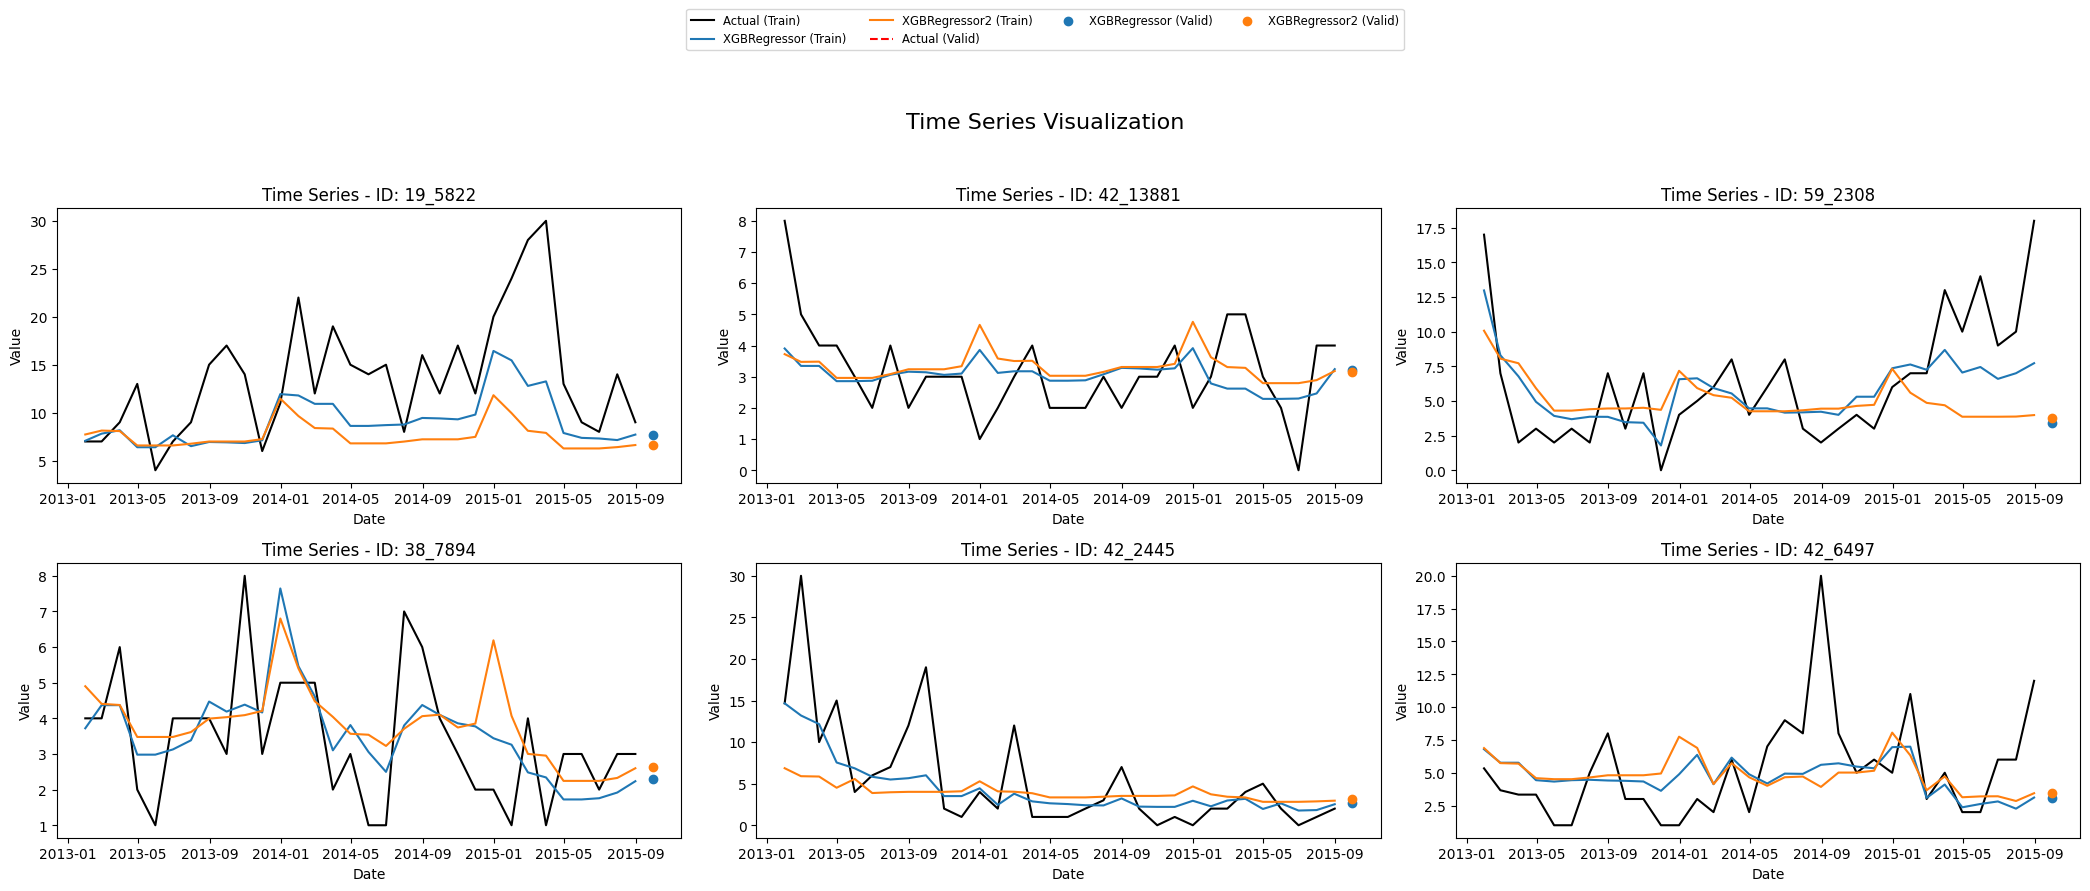

MEAN RMSE_VALID = 3.424864298586424

Model with lowest RMSE validation is XGBRegressor with RMSE = 3.082267095440107

               RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor     3.909557  0.763847    3.082267  0.825471
XGBRegressor2    5.113777  0.595962    3.767462  0.739250


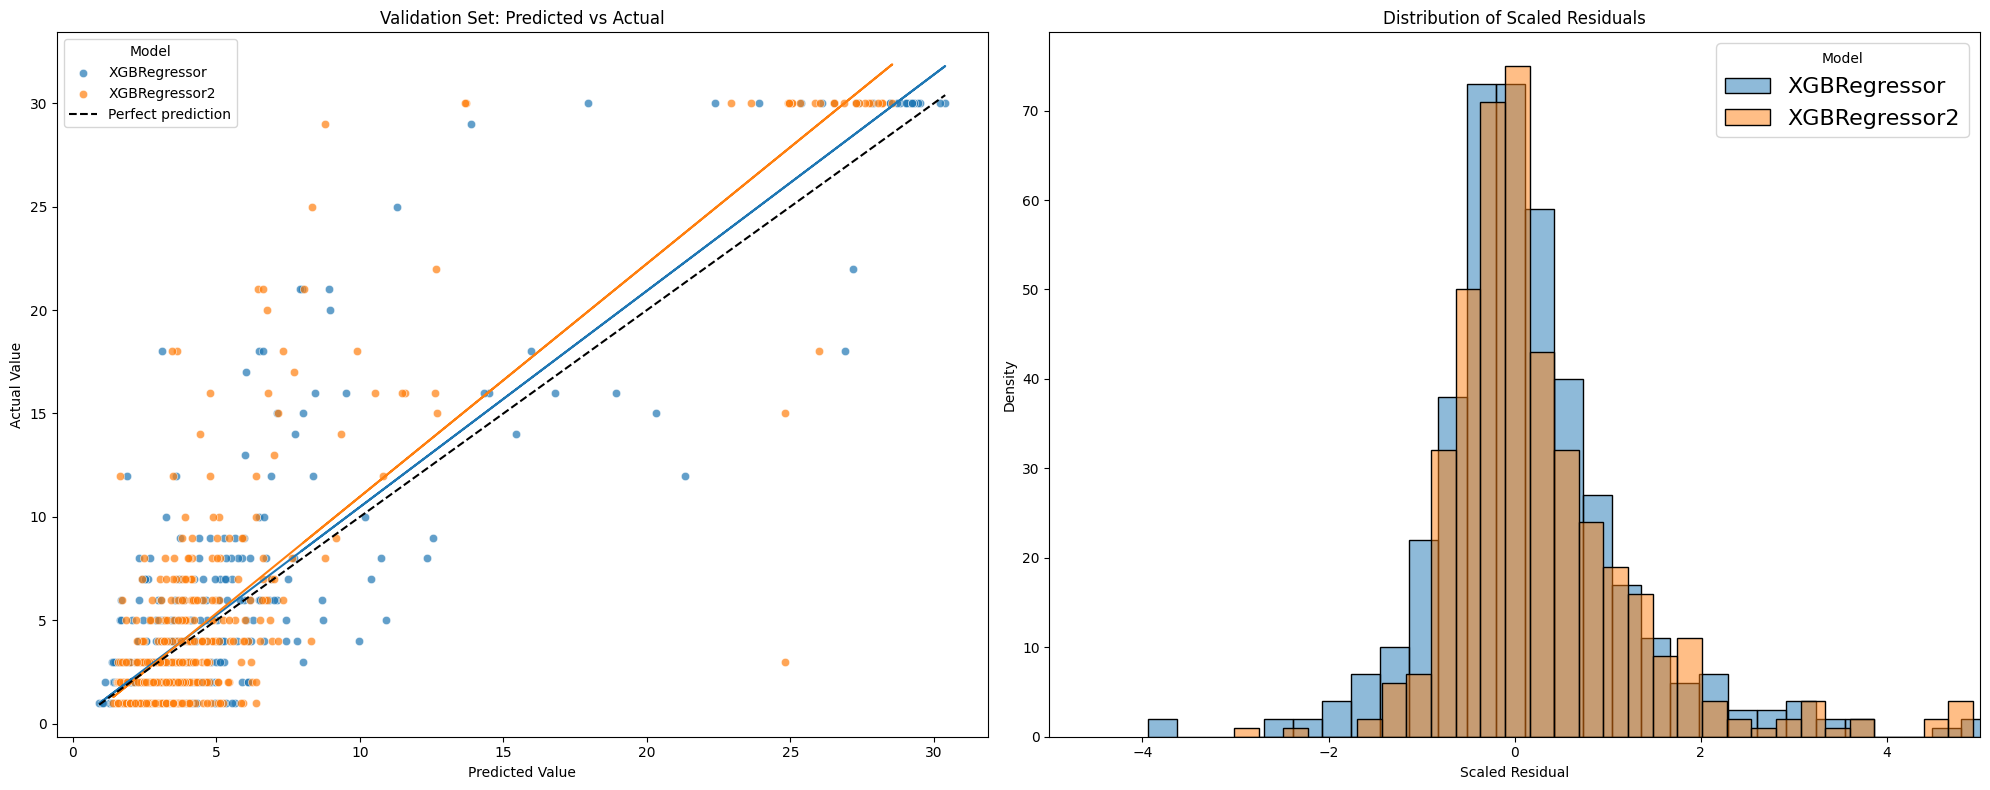

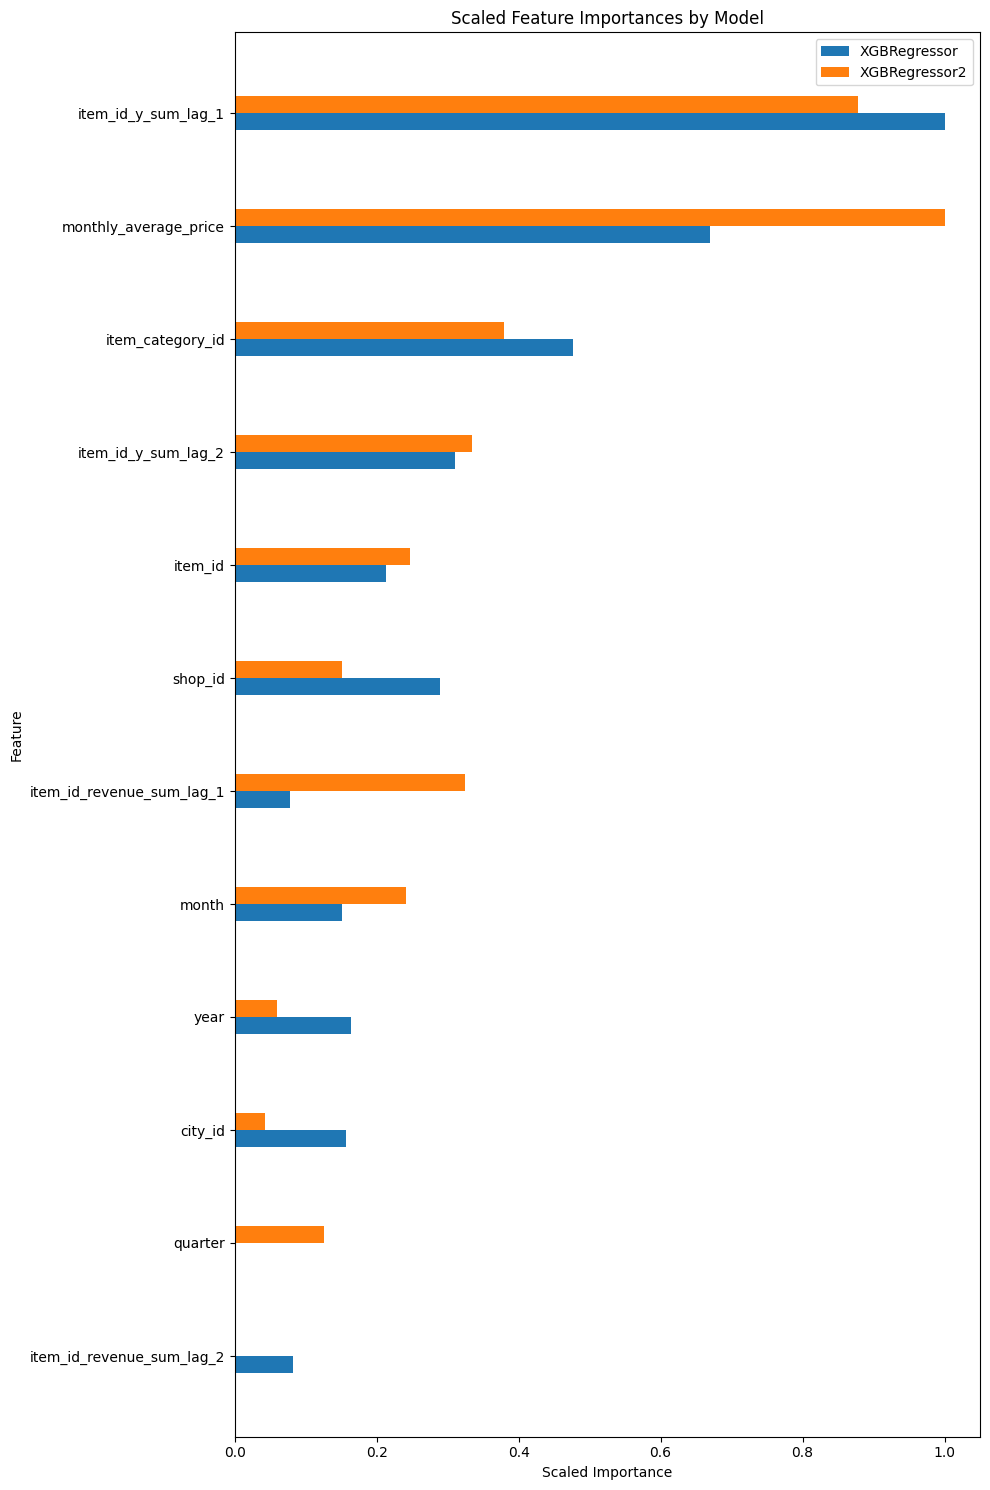

In [638]:
# Assuming you have your fcst object and valid set ready
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)

# Plot time series
evaluator.plot_time_series(n_samples=6)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

In [639]:
train.drop(columns=static_features+core_features, axis=1).dropna().corr().style.background_gradient(cmap='coolwarm')

,monthly_average_price,y,month,year,quarter,item_id_y_sum_lag_1,item_id_y_sum_lag_2,item_id_revenue_sum_lag_1,item_id_revenue_sum_lag_2
monthly_average_price,1.000000,0.132298,0.004828,0.005243,0.003124,0.136265,0.133316,0.442271,0.410416
y,0.132298,1.000000,0.024845,-0.110408,0.016894,0.825359,0.680032,0.578858,0.546486
month,0.004828,0.024845,1.000000,-0.358497,0.967199,-0.072305,-0.087376,-0.004366,-0.010853
year,0.005243,-0.110408,-0.358497,1.000000,-0.336887,-0.073589,-0.066746,-0.066936,-0.065608
quarter,0.003124,0.016894,0.967199,-0.336887,1.000000,-0.067200,-0.090032,0.002388,-0.010838
item_id_y_sum_lag_1,0.136265,0.825359,-0.072305,-0.073589,-0.067200,1.000000,0.774405,0.641941,0.587029
item_id_y_sum_lag_2,0.133316,0.680032,-0.087376,-0.066746,-0.090032,0.774405,1.000000,0.512640,0.648743
item_id_revenue_sum_lag_1,0.442271,0.578858,-0.004366,-0.066936,0.002388,0.641941,0.512640,1.000000,0.723545
item_id_revenue_sum_lag_2,0.410416,0.546486,-0.010853,-0.065608,-0.010838,0.587029,0.648743,0.723545,1.000000


# Predicting future values (test)

In [640]:
# Predict h=2 and save second prediction as submission
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=2)
evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'XGBRegressor'
evaluator.predict_save_submission(model, test_index=test_index)

MEAN RMSE_VALID = 3.424864298586424

Model with lowest RMSE validation is XGBRegressor with RMSE = 3.082267095440107

               RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor     3.909557  0.763847    3.082267  0.825471
XGBRegressor2    5.113777  0.595962    3.767462  0.739250
Submission file 'submissions\submission_XGBRegressor_mean_valid_RMSE_3.4249_2024-07-10.csv' has been created successfully.


,unique_id,monthly_sales
1,12_11365,14.071913
3,12_11369,28.176790
5,12_11370,30.066343
7,12_11373,28.742399
9,12_12231,1.721724
...,...,...
843,7_5822,9.736418
845,7_6185,12.275258
847,7_6497,18.060398
849,7_7856,13.597409


# Predicting future values (test) with train+valid fit

In [641]:
test_index = [sorted(list(data["ds"].unique()))[-1]]
train = data.loc[~data['ds'].isin(test_index)] #train is now all data except the last month
valid = data.loc[data['ds'].isin(valid_index)] #valid RMSE will be unrealistic but I need it for evaluator
test = data.loc[data['ds'].isin(test_index)]

all_features = list(train.columns)
dynamic_features = list(set(all_features) - set(static_features) - set('y'))

future_df = data[dynamic_features]

In [642]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=static_features)

MLForecast(models=[XGBRegressor, XGBRegressor2], freq=M, lag_features=[], date_features=[], num_threads=1)

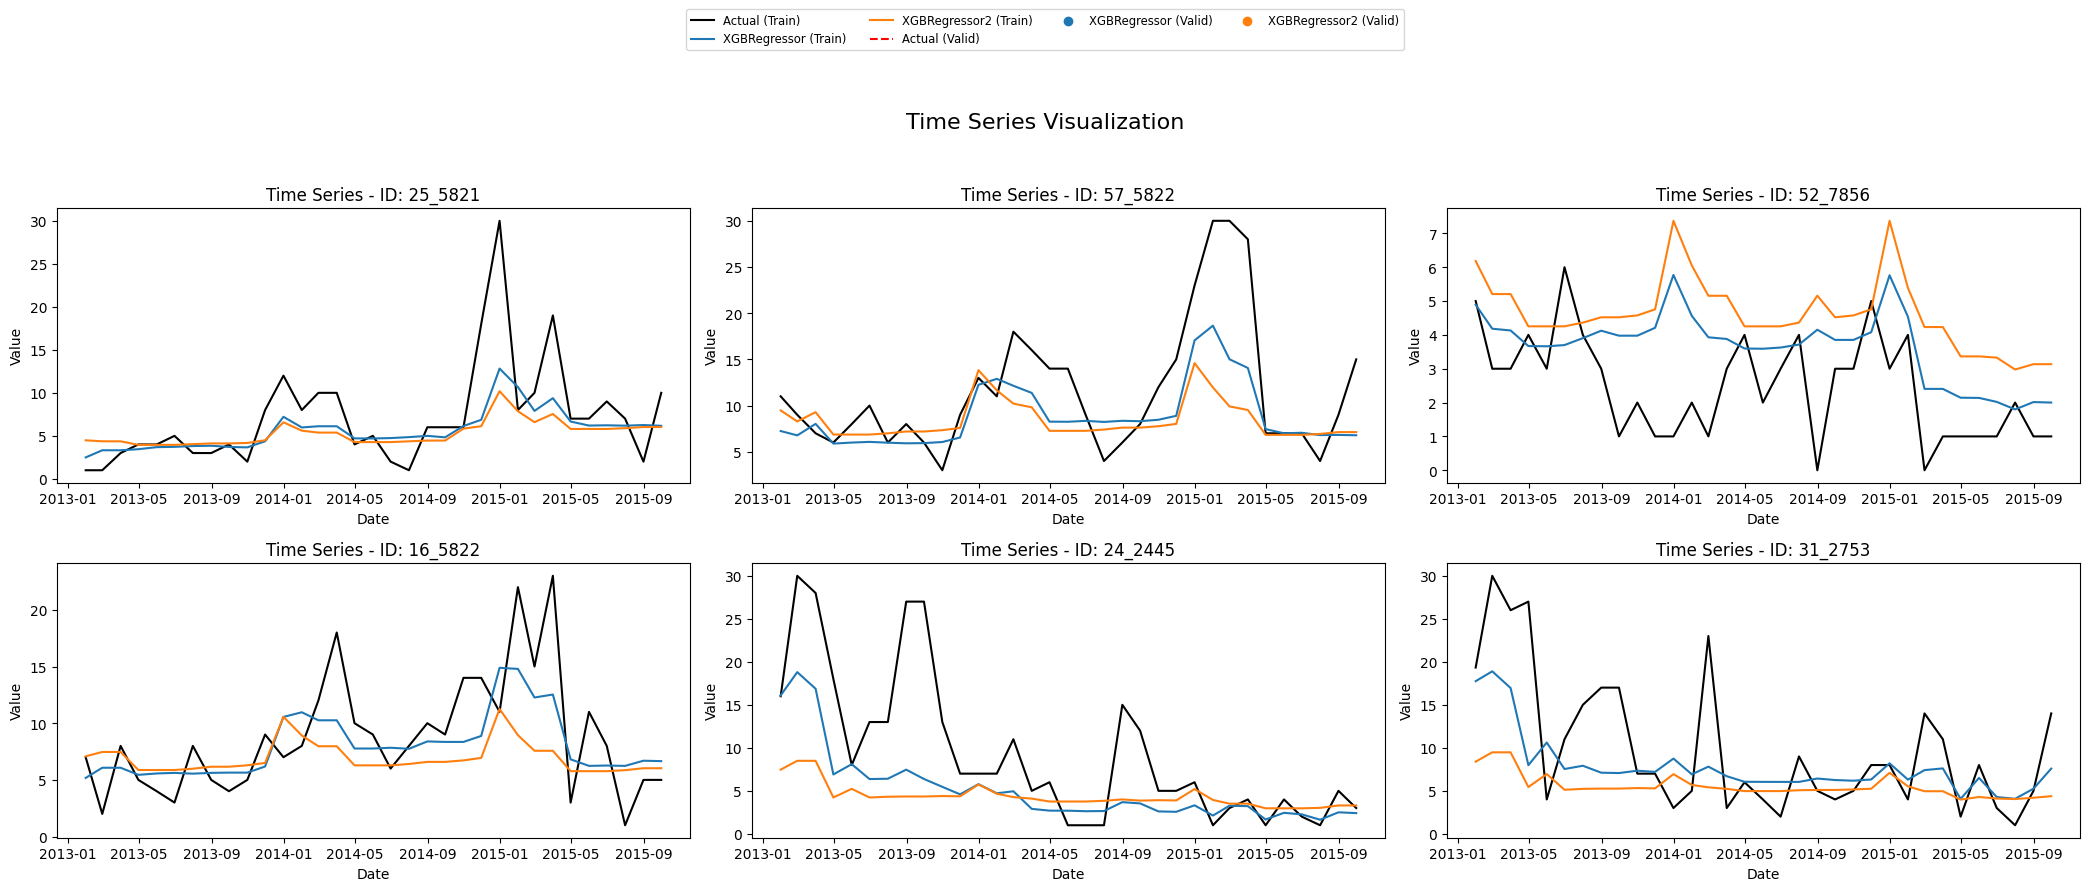

Submission file 'submissions\submission_XGBRegressor_mean_valid_RMSE_unknown_2024-07-10.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,15.794094
1,12_11369,27.020899
2,12_11370,28.469528
3,12_11373,28.381546
4,12_12231,1.881981
...,...,...
421,7_5822,10.796971
422,7_6185,14.350101
423,7_6497,22.680515
424,7_7856,17.128599


In [643]:
# Predict h=2 and save second prediction as submission
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)
#evaluator.calculate_metrics()
evaluator.plot_time_series(n_samples=6)  # Will show 4 random time series in a 2x2 grid

#for model in evaluator.model_columns:
model = 'XGBRegressor'
evaluator.predict_save_submission(model, test_index=test_index)